In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from codecarbon import EmissionsTracker
import time

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


True
0
NVIDIA GeForce RTX 3080 Ti Laptop GPU
using device: cuda


In [2]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

['1401.jpg', '1402.jpg', '1403.jpg', '1404.jpg', '1405.jpg', '1406.jpg', '1407.jpg', '1408.jpg', '1409.jpg', '1410.jpg', '1411.jpg', '1412.jpg', '1413.jpg', '1414.jpg', '1415.jpg', '1416.jpg', '1417.jpg', '1418.jpg', '1419.jpg', '1420.jpg', '1421.jpg', '1422.jpg', '1423.jpg', '1424.jpg', '1425.jpg', '1426.jpg', '1427.jpg', '1428.jpg', '1429.jpg', '1430.jpg', '1431.jpg', '1432.jpg', '1433.jpg', '1434.jpg', '1435.jpg', '1436.jpg', '1437.jpg', '1438.jpg', '1439.jpg', '1440.jpg']


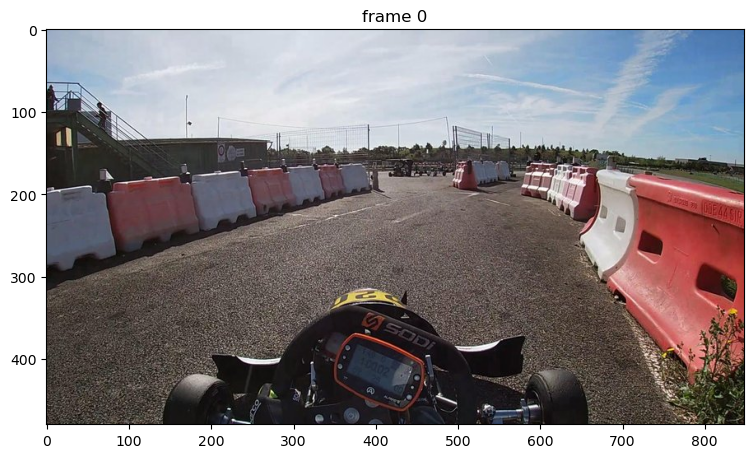

In [296]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../ai4industry/dataset_light/dataset/part000/part28"
save_mask = "partie28"
vis_frame_stride = 10

# # scan all the JPEG frame names in this directory
# frame_names = []
# for i in range(15):  # Répertoires part000 à part014
#     part_dir = f"{video_dir}{i:03d}"  # Construire le chemin vers chaque répertoire
#     if os.path.exists(part_dir):  # Vérifier si le répertoire existe
#         for p in os.listdir(part_dir):  # Lister les fichiers dans chaque répertoire
#             if os.path.splitext(p)[-1].lower() in [".jpg"]:  # Filtrer les fichiers JPEG
#                 frame_names.append(os.path.join(part_dir, p))  # Construire le chemin complet du fichier

# frame_names = [
#     p
#     for p in os.listdir(f for f in os.listdir(video_dir))
#     if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
# ]
# frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split("\\")[1]))

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print(frame_names)
# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [297]:
tracker = EmissionsTracker()

tracker.start()
start_time = time.time()

inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

emissions = tracker.stop()
end_time = time.time()

# Calculer le temps écoulé
elapsed_time = end_time - start_time

# Afficher les résultats
print(f"Les émissions de CO₂ générées sont estimées à {emissions:.6f} kg")
print(f"Le temps d'exécution est de {elapsed_time:.2f} secondes")

[codecarbon INFO @ 17:33:19] [setup] RAM Tracking...
[codecarbon INFO @ 17:33:19] [setup] CPU Tracking...
[codecarbon WARNING @ 17:33:19] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 17:33:20] We saw that you have a 12th Gen Intel(R) Core(TM) i9-12900H but we don't know it. Please contact us.
[codecarbon INFO @ 17:33:20] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i9-12900H
[codecarbon INFO @ 17:33:20] [setup] GPU Tracking...
[codecarbon INFO @ 17:33:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:33:20] >>> Tracker's metadata:
[codecarbon INFO @ 17:33:20]   Platform system: Windows-11-10.0.22631-SP0
[codecarbon INFO @ 17:33:20]   Python version: 3.12.8
[codecarbon INFO @ 17:33:20]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:33:20]   Available RAM : 31.678 GB
[codecarbon INFO @ 17:33:20]   CPU count: 20
[codecarbon INFO @ 17:33:20]   CPU

Les émissions de CO₂ générées sont estimées à 0.000002 kg
Le temps d'exécution est de 1.83 secondes


C:\Users\ZMPM4362\Desktop\AI4Industry\Code\AI4Industry-UseCaseSERLI\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (C:\Users\ZMPM4362\Desktop\AI4Industry\Code\AI4Industry-UseCaseSERLI\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


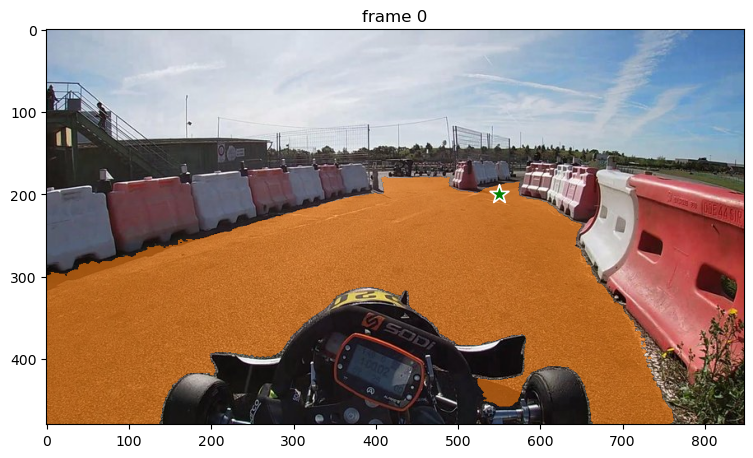

In [298]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[550, 200]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# points = np.array([[580, 400]], dtype=np.float32)

# labels = np.array([0], np.int32)
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )




# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 3: On propage le prompt

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

[codecarbon WARNING @ 17:33:30] Already started tracking
propagate in video: 100%|██████████| 40/40 [00:06<00:00,  6.13it/s]
[codecarbon WARNING @ 17:33:37] Tracker already stopped !
[codecarbon INFO @ 17:33:37] Energy consumed for RAM : 0.000044 kWh. RAM Power : 11.87920618057251 W
[codecarbon INFO @ 17:33:37] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:33:37] Energy consumed for all GPUs : 0.000217 kWh. Total GPU Power : 65.94628432309607 W
[codecarbon INFO @ 17:33:37] 0.000417 kWh of electricity used since the beginning.


Les émissions de CO₂ générées sont estimées à 0.000023 kg
Le temps d'exécution est de 6.66 secondes


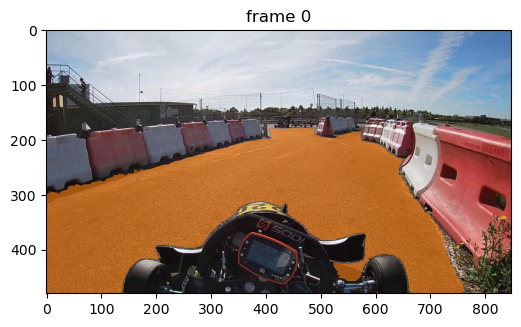

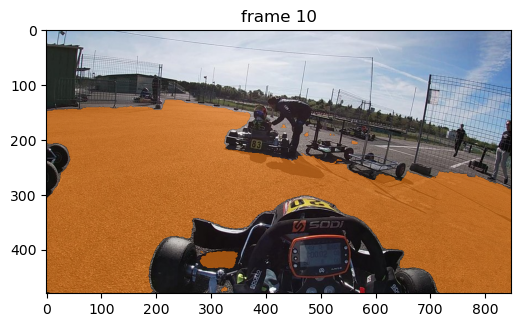

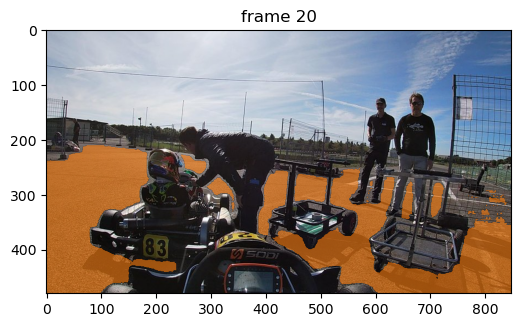

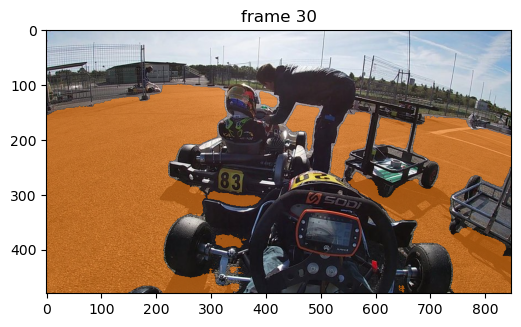

In [299]:
tracker.start()
start_time = time.time()

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames (see vis_frame_stride In14)
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

emissions = tracker.stop()
end_time = time.time()

# Calculer le temps écoulé
elapsed_time = end_time - start_time

# Afficher les résultats
print(f"Les émissions de CO₂ générées sont estimées à {emissions:.6f} kg")
print(f"Le temps d'exécution est de {elapsed_time:.2f} secondes")

### Step 4 : On ajoute de nouveaux prompts pour affiner le mask

In [300]:
# ann_frame_idx = 30  # further refine some details on this frame
# ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# # show the segment before further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- before refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# # Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
# points = np.array([[1213, 365]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
# _, _, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the segment after the further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- after refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

In [301]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }

# # render the segmentation results every few frames (see vis_frame_stride In14)
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Step 5 : Export des données

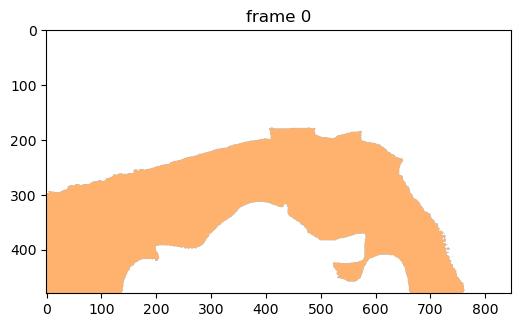

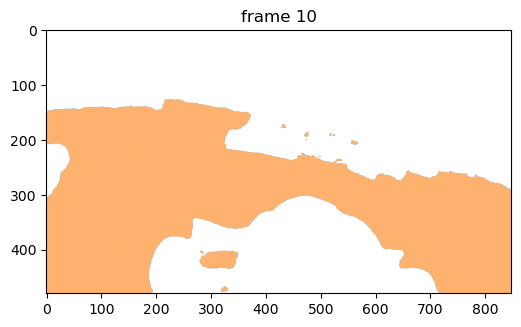

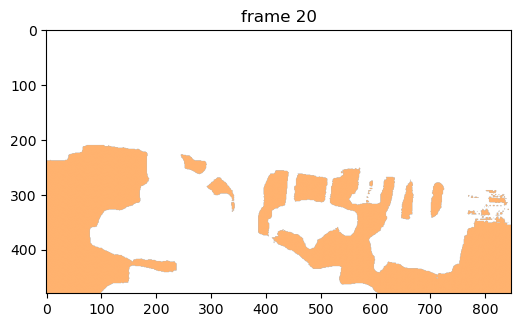

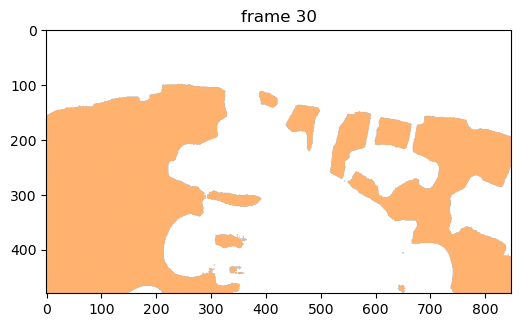

In [302]:
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [303]:
#print(video_segments[0].items())

value = video_segments[0][1].shape
print(value)
road_points=[[]]
for i in range(video_segments[0][1].shape[1]):
    for j in range(video_segments[0][1].shape[2]):
        if video_segments[0][1][0,i,j]:
            road_points[0].append([i,j])

print(len(road_points[0]))
print(video_segments)


(1, 480, 848)
125207
{0: {1: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]],
      shape=(1, 480, 848))}, 1: {1: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]],
      shape=(1, 480, 848))}, 2: {1: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
 

In [304]:
# import json

# def add_road_points_to_files(json_folder, road_points):
#     """
#     Ajoute la liste `road_points` correspondante à chaque fichier JSON.
    
#     :param json_folder: Chemin vers le dossier contenant les fichiers JSON.
#     :param road_points: Liste de listes contenant les points associés à chaque fichier JSON.
#     """
#     for i, points in enumerate(road_points):  # Indice 0 correspond à 0001.json
#         json_file = os.path.join(json_folder, f"{i + 1:04d}.json")  # Décalage de +1
        
#         if not os.path.exists(json_file):
#             print(f"Le fichier {json_file} n'existe pas. Ignoré.")
#             continue
        
#         # Charger le fichier JSON
#         with open(json_file, 'r') as f:
#             data = json.load(f)
        
#         # Ajouter les road_points
#         data['road_points'] = points
        
#         # Écrire le fichier mis à jour
#         with open(json_file, 'w') as f:
#             json.dump(data, f, indent=4)


# def create_consolidated_file(json_folder, road_points, output_file):
#     """
#     Crée un fichier JSON consolidé contenant toutes les données.
    
#     :param json_folder: Chemin vers le dossier contenant les fichiers JSON.
#     :param road_points: Liste de listes contenant les points associés à chaque fichier JSON.
#     :param output_file: Chemin du fichier JSON consolidé de sortie.
#     """
#     consolidated_data = []
    
#     for i, points in enumerate(road_points):  # Indice 0 correspond à 0001.json
#         json_file = os.path.join(json_folder, f"{i + 1:04d}.json")  # Décalage de +1
        
#         if not os.path.exists(json_file):
#             print(f"Le fichier {json_file} n'existe pas. Ignoré.")
#             continue
        
#         # Charger le fichier JSON
#         with open(json_file, 'r') as f:
#             data = json.load(f)
        
#         # Construire une entrée consolidée
#         entry = {
#             "name": i + 1,  # Correspond au fichier (0001.json → name: 1)
#             "lat": data["lat"],
#             "lon": data["lon"],
#             "road_points": points
#         }
        
#         # Ajouter à la liste consolidée
#         consolidated_data.append(entry)
    
#     # Écrire le fichier JSON consolidé
#     with open(output_file, 'w') as f:
#         json.dump(consolidated_data, f, indent=4)

# create_consolidated_file(video_dir,road_points,"donnees.json")

In [305]:

mask_arrays = np.zeros((50, 480,848 ), dtype=bool)

for key, value in video_segments.items():
    mask_arrays[key - 1] = np.copy(value[1])
    

print(mask_arrays)
np.save(save_mask,mask_arrays)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal